In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from SCM import ScalarLinearDecisionModel, NewScalarLinearDecisionModel, SelectionBiasDecisionModel
import graph_helper as graph#line_plots, importance_heatmap, diff_importance_heatmap, categorical_heatmap
import optimization_helper as opt #find_pred_improve_lin_cost, find_real_improve_lin_cost
import tensorflow as tf
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


/Users/sophiagunluk/anaconda3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [198]:
def gaussian_kernel(x1, x2, sigma=1.0):
    """
    Gaussian kernel function.
    Args:
        x1: Input data (array-like).
        x2: Input data (array-like).
        sigma: Kernel bandwidth.
    Returns:
        Gaussian kernel value.
    """
    return np.exp(-np.linalg.norm(x1 - x2) ** 2 / (2 * (sigma ** 2)))

def mmd_loss(data0, data1):
    """
    Calculate the Maximum Mean Discrepancy (MMD) loss between two distributions:
    
    Args:
        f: Function that maps input data to a scalar value.
        X: Input data (array-like).
        delta: Value used to perturb X for one distribution.
        delta_hat: Value used to perturb X for the other distribution.
    Returns:
        MMD loss value.
    """

    m = len(data0)
    n = len(data1)

    # Calculate the MMD loss using the Gaussian kernel
    mmd = 0.0
    for i in range(m):
        for j in range(m):
            mmd += gaussian_kernel(data0[i], data0[j])
    for i in range(n):
        for j in range(n):
            mmd += gaussian_kernel(data1[i], data1[j])
    for i in range(m):
        for j in range(n):
            mmd -= 2 * gaussian_kernel(data0[i], data1[j])

    return mmd / (m * (m - 1) + n * (n - 1))
                               
                  
def gaming_mmd(params, data_SCM, pred_fn, delta = 1.0):
    data_pd = data_SCM.get_data_df()
    #gaming_data = gaming_metric(params, data_SCM, pred_fn, delta = 1.0)
    pred_best_delta, pred_best_improvement, pred_which_improve = opt.find_pred_improve_lin_cost(data_SCM, params["cost_fn"], pred_fn, data_pd)

    #Collect Gaming data: P(f_hat(x + delta_hat_x) >= 0.5 | f(x) < 0.5, f(x + delta_hat_x) < 0.5 )

    pred_best_improvement_delta = np.zeros_like(pred_best_improvement)
    pred_best_improvement_delta[pred_best_delta <= delta] = pred_best_improvement[pred_best_delta <= delta]
    f_results_g = data_SCM.generate_y_logit(data = data_pd.loc[data_pd['Y_logit'] < 0],
                                             diff_vec = pred_best_improvement_delta[data_pd['Y_logit'] < 0])

    gaming_pred = np.where(pred_best_delta[data_pd['Y_logit'] < 0][f_results_g < 0] <= delta,1,0)
    filtered_S_g = data_pd['S'][data_pd['Y_logit'] < 0][f_results_g < 0]
    return mmd_loss(gaming_pred[filtered_S_g == 0], gaming_pred[filtered_S_g == 1])


def improvement_mmd(params, data_SCM, pred_fn, delta = 1.0):
    data_pd = data_SCM.get_data_df()
    real_best_delta, real_best_improvement, real_which_improve = opt.find_real_improve_lin_cost(data_SCM, params["cost_fn"], data_pd)
    pred_best_delta, pred_best_improvement, pred_which_improve = opt.find_pred_improve_lin_cost(data_SCM, params["cost_fn"], pred_fn, data_pd)

    # Collect Improvment data: P(f(x + delta_hat_x) >= 0.5 | f(x) < 0.5, f(x + delta_x) >= 0.5)
    filtered_S_i = data_pd['S'][(real_best_delta <= delta) & (data_pd['Y_logit'] < 0)]
    f_results_i = data_SCM.generate_y_logit(data = data_pd.loc[(real_best_delta <= delta) & (data_pd['Y_logit'] < 0)], 
                                            diff_vec = pred_best_improvement[(real_best_delta <= delta) & (data_pd['Y_logit'] < 0)])
            
    improv_results = np.where(f_results_i >= 0, 1, 0) 
       
    return mmd_loss(improv_results[filtered_S_i == 0], improv_results[filtered_S_i == 1])

def simple_pred_improve_opt(n_samples, learned_params, X, delta):
  temp_improve_vec = torch.zeros((n_samples, 2))
  if learned_params["w"][0] <= learned_params["w"][1]: #we change C
      #print(delt)
    temp_improve_vec[:, 1] = torch.maximum(torch.zeros(n_samples), -1*(learned_params["b"] + learned_params["w"][0]*X[:,0])/learned_params["w"][1] - X[:,1])
  else: #we change A
    temp_improve_vec[:, 0] = torch.maximum(torch.zeros(n_samples), -1*(learned_params["b"] + learned_params["w"][1]*X[:,1])/learned_params["w"][0] - X[:,0])
  
  improve_vec = torch.tensor(temp_improve_vec, requires_grad=True)
 
  return improve_vec
            

In [213]:
# Create a simple logistic regression model
class LogisticRegressionModel(nn.Module):
  def __init__(self, input_dim):
    super(LogisticRegressionModel, self).__init__()
    self.linear = nn.Linear(input_dim, 1)
  def forward(self, x):
    return torch.sigmoid(self.linear(x))
  def predict(self, x):
    return torch.where((torch.sigmoid(self.linear(x)) > 0.5), 1, 0)
  def get_coefficients(self):
    return {"w": self.linear.weight.data.view(-1).tolist(), "b": self.linear.bias.item()}
  def accuracy(self, x, true_y):
    correct_pred = torch.where(true_y.clone().detach() == self.predict(x), 1, 0)
    return torch.mean(correct_pred.float().clone().detach().requires_grad_(True))


def loss_penalty(type_loss, params, data_SCM, delta = 1.0, penalty_coef = 500.0):
  def bce_loss(outputs, targets, pred_fn):
    return nn.BCELoss()(outputs, targets)
  def gaming_penalty(outputs, targets, pred_fn):
    data_pd = data_SCM.get_data_df()
    gaming_mmd_loss = gaming_mmd(params, data_SCM, pred_fn, delta = 1.0)
    pred_best_delta, pred_best_improvement, pred_which_improve = opt.find_pred_improve_lin_cost(data_SCM, params["cost_fn"], pred_fn, data_pd)
    gaming_loss = gaming_metric(params, data_SCM, data_pd, pred_fn, pred_best_delta, pred_best_improvement, delta = delta)
    #print(round(gaming_mmd_loss, 3))
    return nn.BCELoss()(outputs, targets) + penalty_coef*abs(gaming_loss[1] - gaming_loss[0])
  def improvement_penalty(outputs, targets, pred_fn):
    improvement_mmd_loss = improvement_mmd(params, data_SCM, pred_fn, delta = 1.0)
    return nn.BCELoss()(outputs, targets) + penalty_coef*improvement_mmd_loss
  def combined_penalty(outputs, targets, pred_fn):
    gaming_mmd_loss = gaming_mmd(params, data_SCM, pred_fn, delta = 1.0)
    improvement_mmd_loss = improvement_mmd(params, data_SCM, pred_fn, delta = 1.0)
    return nn.BCELoss()(outputs, targets) + penalty_coef*(gaming_mmd_loss + improvement_mmd_loss)
  if type_loss == "bce":
    print("BCE LOSS")
    return bce_loss
  elif type_loss == "improvement":
    print("IMPROVEMENT PENALTY LOSS")
    return improvement_penalty
  elif type_loss == "gaming":
    print("GAMING PENALTY LOSS")
    return gaming_penalty
  else:
    print("COMBINED PENALTY LOSS")
    return combined_penalty
# Function to train the model with a customizable loss function
def train_model(X, y, loss_function, num_epochs = 4500, learning_rate = 0.01, make_graphs = False):
  input_dim = X.shape[1]
  model = LogisticRegressionModel(input_dim)
  optimizer = optim.SGD(model.parameters(), lr=learning_rate)
  coefs_data = np.zeros((num_epochs, 2))
  accuracy_data = np.zeros((num_epochs))
  loss_data = np.zeros((num_epochs))
  for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X)
    learned_params = model.get_coefficients()
    loss = loss_function(outputs, y, learned_params)
        
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    coefs_data[epoch] = learned_params["w"]
    accuracy_data[epoch] = model.accuracy(X, y).item()
    loss_data[epoch] = loss.item()
    
    if (epoch + 1) % 100 == 0:
      print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}, Accuracy: {model.accuracy(X, y).item()}')
      print(f'Coefficients: w={learned_params["w"]}, b={learned_params["b"]}')
      if make_graphs:
        fig, axes = plt.subplots(1, 2)
        axes[0].plot(np.arange(epoch), coefs_data[0:epoch, 0], label=f'Learned coefficient of A')
        axes[0].plot(np.arange(epoch), coefs_data[0:epoch, 1], label=f'Learned coefficient of C')
        axes[0].legend()
        axes[1].plot(np.arange(epoch), accuracy_data[0:epoch], label=f'Accuracy of learned model')
        axes[1].plot(np.arange(epoch), loss_data[0:epoch], label=f'Loss of earned model')
        axes[1].legend()
        plt.show()
        
  return model

def train_post_adapt_model(X, y, data_SCM, params_SCM, loss_function, delta, num_epochs = 4500, learning_rate = 0.01, make_graphs = False):
  data_df = data_SCM.get_data_df()
  input_dim = X.shape[1]
  model = LogisticRegressionModel(input_dim)
  optimizer = optim.SGD(model.parameters(), lr=learning_rate)
  coefs_data = np.zeros((num_epochs, 2))
  accuracy_data = np.zeros((num_epochs))
  loss_data = np.zeros((num_epochs))
  for epoch in range(num_epochs):
    # Forward pass
    
    y_hat = model(X)
    learned_params = model.get_coefficients()
    
    improve_vec = simple_pred_improve_opt(params_SCM["n_samples"], learned_params, X.detach(), delta)

    delta_filter = torch.tensor((torch.sum(improve_vec, axis=1) <= delta))
    temp_improve_vec_delta = torch.zeros_like(improve_vec)
    temp_improve_vec_delta[delta_filter] = improve_vec[delta_filter]
    improve_vec_delta = torch.tensor(temp_improve_vec_delta, requires_grad=True)
    y_hat_post = torch.max(torch.tensor(delta_filter), torch.tensor(y_hat).view(-1))
    
    y_post = torch.where(torch.tensor(data_df['Y_logit']) + params_SCM["c_y_const"]*improve_vec_delta[:, 1] >= 0, 1, 0)
    
    loss = loss_function(torch.tensor(y_hat_post, requires_grad=True), torch.tensor(y_post, dtype=torch.float, ), learned_params)
        
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    coefs_data[epoch] = learned_params["w"]
    accuracy_data[epoch] = model.accuracy(X, y).item()
    loss_data[epoch] = loss.item()
    
    if (epoch + 1) % 100 == 0:
      print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}, Accuracy: {model.accuracy(X, y).item()}')
      print(f'Coefficients: w={learned_params["w"]}, b={learned_params["b"]}')
      if make_graphs:
        fig, axes = plt.subplots(1, 2)
        axes[0].plot(np.arange(epoch), coefs_data[0:epoch, 0], label=f'Learned coefficient of A')
        axes[0].plot(np.arange(epoch), coefs_data[0:epoch, 1], label=f'Learned coefficient of C')
        axes[0].legend()
        axes[1].plot(np.arange(epoch), accuracy_data[0:epoch], label=f'Accuracy of learned model')
        axes[1].plot(np.arange(epoch), loss_data[0:epoch], label=f'Loss of earned model')
        axes[1].legend()
        plt.show()
        
  return model




In [144]:
def gaming_metric(params, data_SCM, data_pd, pred_fn, pred_best_delta, pred_best_improvement, delta = 1.0):
    #pred_best_delta, pred_best_improvement, pred_which_improve = opt.find_pred_improve_lin_cost(data_SCM, params["cost_fn"], pred_fn, data_pd)

    #Collect Gaming data: P(f_hat(x + delta_hat_x) >= 0.5 | f(x) < 0.5, f(x + delta_hat_x) < 0.5 )
    
    pred_best_improvement_delta = np.zeros_like(pred_best_improvement)
    pred_best_improvement_delta[pred_best_delta <= delta] = pred_best_improvement[pred_best_delta <= delta]
    f_results_g = data_SCM.generate_y_logit(data = data_pd.loc[data_pd['Y_logit'] < 0],
                                             diff_vec = pred_best_improvement_delta[data_pd['Y_logit'] < 0])

    gaming_pred = np.where(pred_best_delta[data_pd['Y_logit'] < 0][f_results_g < 0] <= delta,1,0)
    filtered_S_g = data_pd['S'][data_pd['Y_logit'] < 0][f_results_g < 0]
    
    return np.array([np.mean(gaming_pred[filtered_S_g == 0]), np.mean(gaming_pred[filtered_S_g == 1])])
          
def improvement_metric(params, data_SCM, data_pd, real_best_delta, real_best_improvement, pred_fn, pred_best_delta, pred_best_improvement,delta = 1.0):
    #real_best_delta, real_best_improvement, real_which_improve = opt.find_real_improve_lin_cost(data_SCM, params["cost_fn"], data_pd)
    #pred_best_delta, pred_best_improvement, pred_which_improve = opt.find_pred_improve_lin_cost(data_SCM, params["cost_fn"], pred_fn, data_pd)

    # Collect Improvment data: P(f(x + delta_hat_x) >= 0.5 | f(x) < 0.5, f(x + delta_x) >= 0.5)
    pred_best_improvement_delta = np.zeros_like(pred_best_improvement)
    pred_best_improvement_delta[pred_best_delta <= delta] = pred_best_improvement[pred_best_delta <= delta]
    
    filtered_S_i = data_pd['S'][(real_best_delta <= delta) & (data_pd['Y_logit'] < 0)]
    f_results_i = data_SCM.generate_y_logit(data = data_pd.loc[(real_best_delta <= delta) & (data_pd['Y_logit'] < 0)], 
                                            diff_vec = pred_best_improvement_delta[(real_best_delta <= delta) & (data_pd['Y_logit'] < 0)])
            
    improv_results = np.where(f_results_i >= 0, 1, 0) 
       
    return np.array([np.mean(improv_results[filtered_S_i == 0]), np.mean(improv_results[filtered_S_i == 1])])
            

In [138]:
def scatterplots_U(params, data_SCM, decision_boundary, pred_y, delta = 1.0, save = False, folder_name = "graphs/"):
    # Train a logistic regression model
    data_pd = data_SCM.get_data_df()
    true_y = np.where(data_pd["Y_logit"] >= 0, 1, 0)
    
    pred_best_delta, pred_best_improvement, pred_which_improve = opt.find_pred_improve_lin_cost(data_SCM, params["cost_fn"], decision_boundary, data_pd)
    real_best_delta, real_best_improvement, real_which_improve = opt.find_real_improve_lin_cost(data_SCM, params["cost_fn"], data_pd)

    print(np.mean(data_pd["U"]))
    print(np.mean(data_SCM.U - data_SCM.u_noise))

    # Create the plot
    fig, axes = plt.subplots(3, 2, figsize=(20, 24))

    # Create titles
    axes[0, 0].set_title("S = 0, U = 0")
    axes[0, 1].set_title("S = 0, U = 1")
    axes[1, 0].set_title("S = 1, U = 0")
    axes[1, 1].set_title("S = 1, U = 1")
    axes[2, 0].set_title("Total Population, U = 0")
    axes[2, 1].set_title("Total Population, U = 1")

    for i in range(len(data_pd["A"])):
        #plot points
        if data_pd["S"][i] == 0:
            # Plot points based on S and Y values for "minority members"
            marker = 'r' if real_best_delta[i] > delta or real_best_delta[i] <= 0 else 'g'
            marker += 'o' if data_pd["Y"][i] > 0 else 'x'
            axes[0, int(data_pd["U_binary"][i])].plot(data_pd["A"][i], data_pd["C"][i], marker)
            #marker = 'ro' if data_train_pd["Y"][i] > 0 else 'rx'
        if data_pd["S"][i] == 1:
            # Plot points based on S and Y values for "majority members"
            marker = 'b' if real_best_delta[i] > delta or real_best_delta[i] <= 0 else 'm'
            marker += 'o' if data_pd["Y"][i] > 0 else 'x'
            axes[1, int(data_pd["U_binary"][i])].plot(data_pd["A"][i], data_pd["C"][i], marker)
            #marker = 'bo' if data_train_pd["Y"][i] > 0 else 'bx'
        axes[2, int(data_pd["U_binary"][i])].plot(data_pd["A"][i], data_pd["C"][i], marker)

    # Plot decision boundaries

    lim = max(-1*np.max(data_pd["A"]), np.max(data_pd["A"]),
                 np.max(-1*data_pd["C"]), np.max(data_pd["C"]))
    # Plot the pred decision boundary
    
    
    # Plot the real decision boundary
    # Create an SVM classifier with a linear kernel
    coefs = decision_boundary["w"]
    intercept = decision_boundary["b"]
    
    print("gaming")
    g_data = gaming_metric(params, data_SCM, data_pd, decision_boundary, pred_best_delta, pred_best_improvement, delta = delta)
    print("minority: ", g_data[0], ", majority: ",  g_data[1])
    #print(nn.BCELoss()(torch.tensor(pred_y, dtype=torch.long), y_tensor))
    print((abs(g_data[1] - abs(g_data[0]))))
    print("improvement")
    i_data = improvement_metric(params, data_SCM, data_pd, real_best_delta, real_best_improvement, 
                                decision_boundary, pred_best_delta, pred_best_improvement, delta = delta)
    print("minority: ", i_data[0], ", majority: ",  i_data[1])
    x_boundary = np.linspace(-1*lim, lim, 100)
    y_boundary = (-coefs[0] * x_boundary - intercept) / coefs[1]
    a = np.arange(-1*lim, lim+1, 1)
    for u in range(2):
      for s in range(3):
        
        axes[s, u].plot(x_boundary, y_boundary, color='0.5', linestyle='--', label='$\hat{f}(C,A)=0.5$')
        axes[s, u].plot(a, np.ones_like(a)*-1*params['u_y_const']*u/params['c_y_const'], color='k',
                          linestyle='-.', label = '$\mathbb{E}[Y|C,U=$'+str(u)+'$]=0.5$')
        axes[s, u].set_xlabel('A values')
        axes[s, u].set_ylabel('C values')
        axes[s, u].legend()
    
    
    if save:
        plt.savefig(folder_name + "A_C_plots")

    # Show the plot
    plt.show()
    




In [139]:
def plot_logistic_regression(params, delta = 1.0, type_loss = "gaming", penalty_coef = 1.0, save = False, folder_name = "graphs/"):
    # Train a logistic regression model
    data_train = NewScalarLinearDecisionModel(params)
    data_train.generate_basic_data()
    data_train_pd = data_train.get_data_df()
    X = data_train.get_features()
    y = data_train_pd["Y"]
    #model = LogisticRegression()
    #model.fit(X, y)
    
    X_tensor = torch.tensor(X, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)
    
    
    loss_function = loss_penalty(type_loss = type_loss, params = params, data_SCM = data_train, delta = 1.0, 
                                 penalty_coef = penalty_coef)

    model = train_model(X = X_tensor, y = y_tensor, loss_function = loss_function, make_graphs = True)
    pred_y = model.predict(X_tensor)
    
    decision_boundary = model.get_coefficients()
    
    scatterplots_U(params, data_train, decision_boundary, pred_y, delta = delta, save = save, folder_name = folder_name)
    
    

In [157]:
def plot_improvement(params, delta = 1, save = False, folder_name = "graphs/"):
    # Train a logistic regression model
    data_train = NewScalarLinearDecisionModel(params)
    data_train.generate_basic_data()
    data_train_pd = data_train.get_data_df()
    X = data_train.get_features()
    y = data_train_pd["Y"]
    X_tensor = torch.tensor(X, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)
    
    loss_function = loss_penalty(type_loss = "bce", params = params, data_SCM = data_train, delta = 1.0)

    model = train_post_adapt_model(X = X_tensor, y = y_tensor, data_SCM = data_train, params_SCM = params, 
                                   loss_function = loss_function, delta = delta, make_graphs = True)
    pred_y = model.predict(X_tensor)
        
    pred_fn = model.get_coefficients()
    
    real_best_delta, real_best_improvement, real_which_improve = opt.find_real_improve_lin_cost(data_train, default_params["cost_fn"], data_train_pd)
    pred_best_delta, pred_best_improvement, pred_which_improve = opt.find_pred_improve_lin_cost(data_train, default_params["cost_fn"], pred_fn, data_train_pd)

    pred_best_improvement_delta = np.zeros_like(pred_best_improvement)
    pred_best_improvement_delta[pred_best_delta <= delta] = pred_best_improvement[pred_best_delta <= delta]
    
    print(np.mean(data_train_pd["U"]))
    print(np.mean(data_train.U - data_train.u_noise))

    # Create the plot
    fig, axes = plt.subplots(3, 2, figsize=(20, 24), sharex=True, sharey=True)

    # Create titles
    axes[0, 0].set_title("S = 0, before improvement")
    axes[0, 1].set_title("S = 0, after improvement")
    axes[1, 0].set_title("S = 1, before improvement")
    axes[1, 1].set_title("S = 1, after improvement")
    axes[2, 0].set_title("Total Population, before improvement")
    axes[2, 1].set_title("Total Population, after improvement")

    for i in range(len(data_train_pd["A"])):
        #plot points
        if data_train_pd["S"][i] == 0:
            # Plot points based on S and Y values for "minority members"
            marker = 'g' if real_best_delta[i] <= 1 and real_best_delta[i] > 0 else 'r'
            marker += 'o' if data_train_pd["Y"][i] > 0 else 'x'
            axes[0, 0].plot(data_train_pd["A"][i], data_train_pd["C"][i], marker)
            axes[0, 1].plot(data_train_pd["A"][i]+pred_best_improvement_delta[i,0], data_train_pd["C"][i]+pred_best_improvement_delta[i,1], marker)
            #marker = 'ro' if data_train_pd["Y"][i] > 0 else 'rx'
        if data_train_pd["S"][i] == 1:
            # Plot points based on S and Y values for "majority members"
            marker = 'm' if real_best_delta[i] <= 1 and real_best_delta[i] > 0 else 'b'
            marker += 'o' if data_train_pd["Y"][i] > 0 else 'x'
            axes[1, 0].plot(data_train_pd["A"][i], data_train_pd["C"][i], marker)
            axes[1, 1].plot(data_train_pd["A"][i]+pred_best_improvement_delta[i,0], data_train_pd["C"][i]+pred_best_improvement_delta[i,1], marker)
            #marker = 'bo' if data_train_pd["Y"][i] > 0 else 'bx'
        axes[2, 0].plot(data_train_pd["A"][i], data_train_pd["C"][i], marker)
        axes[2, 1].plot(data_train_pd["A"][i]+pred_best_improvement_delta[i,0], data_train_pd["C"][i]+pred_best_improvement_delta[i,1], marker)

    # Plot decision boundaries

    lim = max(-1*np.max(data_train_pd["A"]), np.max(data_train_pd["A"]),
                 np.max(-1*data_train_pd["C"]), np.max(data_train_pd["C"]))
    # Plot the pred decision boundary
    
    
    # Plot the real decision boundary
    # Create an SVM classifier with a linear kernel
    coef = pred_fn["w"]  # Get the coefficients of the decision boundary
    intercept = pred_fn["b"]
    x_boundary = np.linspace(-1*lim, lim, 100)
    y_boundary = (-coef[0] * x_boundary - intercept) / coef[1]
    a = np.arange(-1*lim, lim+1, 1)
    for t in range(2):
      for s in range(3):
        axes[s, t].plot(x_boundary, y_boundary, color='0.5', linestyle='--', label='$\hat{f}(C,A)=0.5$')
        axes[s, t].plot(a, np.ones_like(a)*-1*params['u_y_const']*(0)/params['c_y_const'], color='k',
                          linestyle='-.', label = '$\mathbb{E}[Y|C,U=0]=0.5$')
        axes[s, t].plot(a, np.ones_like(a)*-1*params['u_y_const']*(1)/params['c_y_const'], color='k',
                          linestyle='-.', label = '$\mathbb{E}[Y|C,U=1]=0.5$')
        
        axes[s, t].set_xlabel('A values')
        axes[s, t].set_ylabel('C values')
    for t in range(2):
      for s in range(3):
        axes[s, t].legend()
    
    
    if save:
        plt.savefig(folder_name + "A_C_plots")

    # Show the plot
    plt.show()
    




In [120]:
def line_grid_search(SCM_params, delta = 1, w_A_C_ratio_array = np.arange(0, 1.5, 0.1), b_array = np.arange(-1.5, 1.5, 0.5)):
  data = NewScalarLinearDecisionModel(SCM_params)
  data.generate_basic_data()
  data_df = data.get_data_df()
  accuracy = np.empty((w_A_C_ratio_array.shape[0], b_array.shape[0]))
  improvement = np.empty((w_A_C_ratio_array.shape[0], b_array.shape[0], 2))
  gaming = np.empty((w_A_C_ratio_array.shape[0], b_array.shape[0], 2))
  accuracy_U = np.empty((w_A_C_ratio_array.shape[0], b_array.shape[0], 2))
  improvement_U = np.empty((w_A_C_ratio_array.shape[0], b_array.shape[0], 2, 2))
  gaming_U = np.empty((w_A_C_ratio_array.shape[0], b_array.shape[0], 2, 2))
  for i, w_A_C_ratio in enumerate(w_A_C_ratio_array):
    for j, b in enumerate(b_array):
      #print("w_A_C_ratio: ", w_A_C_ratio, ", b: ", b)
      pred_fn = {'w': np.array([w_A_C_ratio, 1]), 'b': b} 
      real_improve_vec = np.zeros((SCM_params["n_samples"], 2))
      real_improve_vec[:,1] = np.maximum(0, -1*data_df['Y_logit']/SCM_params["c_y_const"])
      improve_vec = np.zeros((SCM_params["n_samples"], 2))
      if w_A_C_ratio <= 1: #we change C
        #print(delt)
        improve_vec[:, 1] = np.maximum(0, -1*(b + w_A_C_ratio*data.A) - data.C)
      else: #we change A
        improve_vec[:, 0] = np.maximum(0, -1*(b + data.C)/w_A_C_ratio - data.A)
      y_hat = np.where(w_A_C_ratio*data.A + b >= -1*data.C, 1, 0)
      delta_filter = (np.sum(improve_vec, axis=1) <= delta)
      y_hat_post = np.maximum(delta_filter, y_hat)
      improve_vec_delta = np.zeros_like(improve_vec)
      improve_vec_delta[delta_filter] = improve_vec[delta_filter]
      y_post = np.where(data_df['Y_logit'] + SCM_params["c_y_const"]*improve_vec_delta[:, 1] >= 0, 1, 0)
      improvement[i,j,:] = improvement_metric(SCM_params, data, data_df,  np.sum(real_improve_vec, axis=1), real_improve_vec, 
                                                  pred_fn,  np.sum(improve_vec, axis=1), improve_vec, delta)
      gaming[i,j,:] = gaming_metric(SCM_params, data, data_df, pred_fn,  np.sum(improve_vec, axis=1), improve_vec, delta)
      for u in range(2):
        accuracy_U[i,j] = np.mean(y_post[data_df["U"] == u] == y_hat_post[data_df["U"] == u])
        improvement_U[i,j,u,:] = improvement_metric(SCM_params, data, data_df.loc[data_df["U"] == u],  
                                                        np.sum(real_improve_vec[data_df["U"] == u], axis=1), 
                                                        real_improve_vec[data_df["U"] == u], pred_fn,  
                                                        np.sum(improve_vec[data_df["U"] == u], axis=1), 
                                                        improve_vec[data_df["U"] == u], delta)
        gaming_U[i,j,u,:] = gaming_metric(SCM_params, data, data_df.loc[data_df["U"] == u], pred_fn,  
                                              np.sum(improve_vec[data_df["U"] == u], axis=1), 
                                              improve_vec[data_df["U"] == u], delta)

  if True:
    best_vars_idx = np.unravel_index(np.argmax(accuracy), accuracy.shape)
    best_w_A_C_ratio = w_A_C_ratio_array[best_vars_idx[0]]
    best_b = b_array[best_vars_idx[1]]
    best_decision_boundary = {"w": np.array([best_w_A_C_ratio, 1]), "b": best_b}
    pred_y = np.where(best_w_A_C_ratio*data.A + best_b >= -1*data.C, 1, 0)
    scatterplots_U(SCM_params, data, best_decision_boundary, pred_y, delta = delta, save = False)
    
  results = {
      "accuracy": accuracy,
      "improvement": improvement,
      "gaming": gaming,
      "accuracy_U": accuracy_U,
      "improvement_U": improvement_U,
      "gaming_U": gaming_U,
  }
  return results
          
  

In [121]:
default_params = {
    'n_samples': 1000, 
    'input_dim': 2,
    'intervention_dim': 2,
    'p_majority': 0.5,
    's_u_const': 0,
    'u_var': 1,
    's_a_const': 1, 
    'u_a_const': 1,
    'a_var': 1, 
    's_c_const': 1,  
    'a_c_const': 1, 
    'c_var': 1, 
    's_y_const': 1, 
    'c_y_const': 1,
    'u_y_const': 1,
    'y_var': 0.1,
    'cost_fn': {'w': np.array([1, 1]),'b': 0},
}

/Users/sophiagunluk/anaconda3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/sophiagunluk/anaconda3/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0.534
0.5161386585782572
gaming
minority:  0.0 , majority:  0.0
0.0
improvement
minority:  0.0 , majority:  0.0


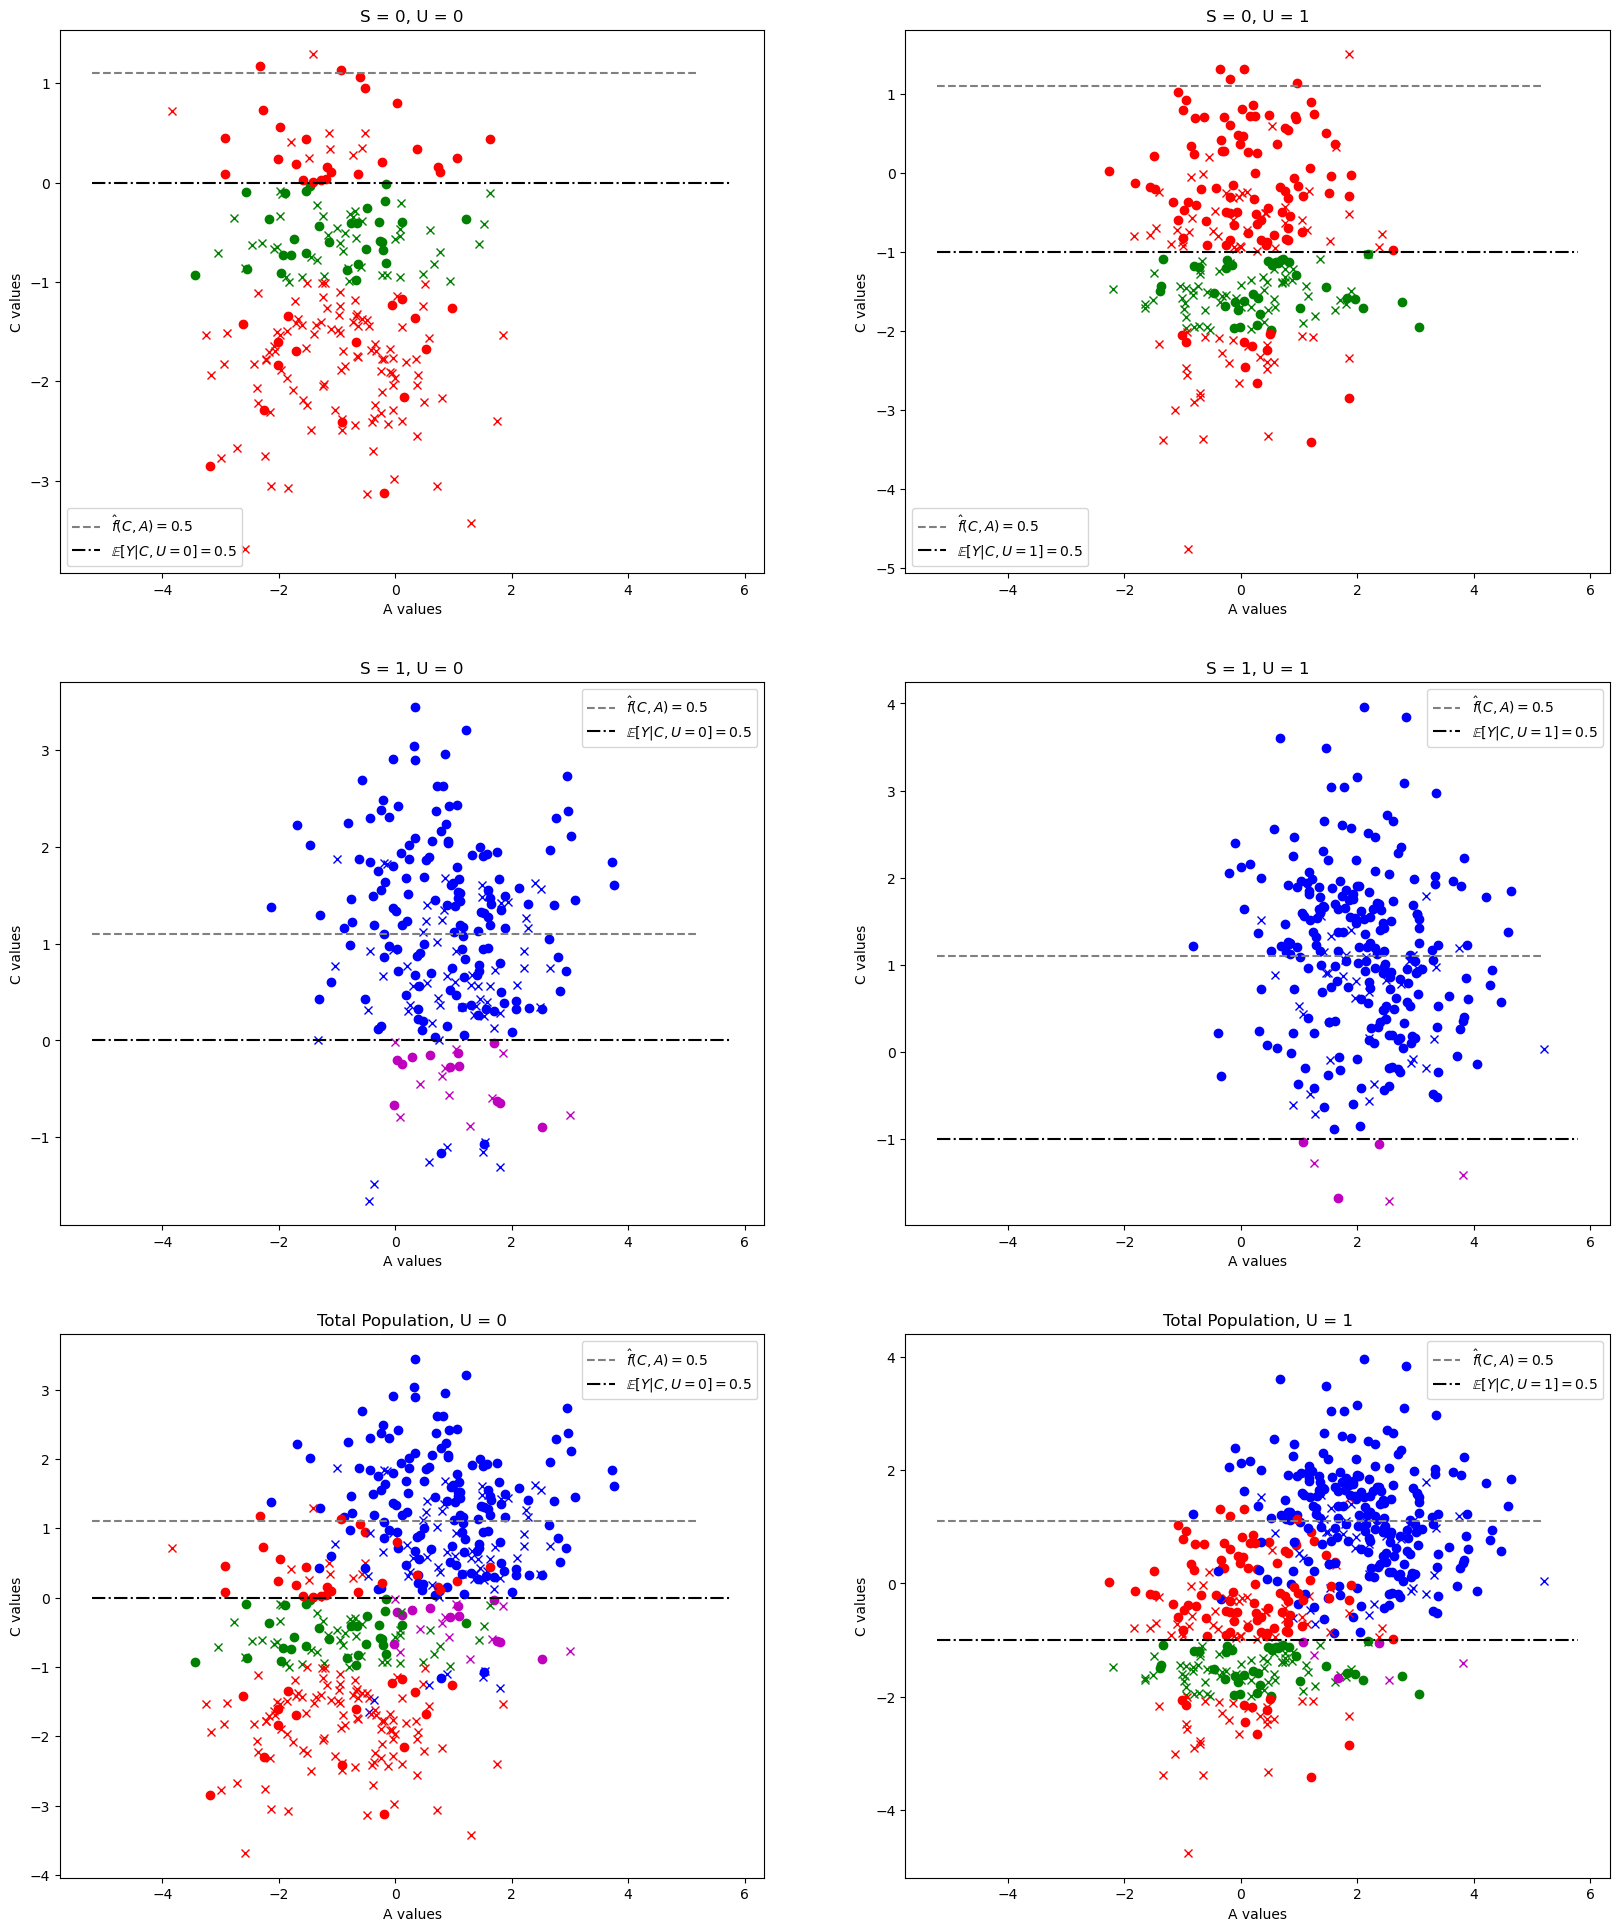

In [86]:
test_params= default_params.copy()

test_params["str_vars"] = np.array(["w_A", "b"])
test_params["vars_0"] = np.arange(0, 1.5, 0.1)
test_params["vars_1"] = np.arange(-1.5, 1.5, 0.2)


test_results = line_grid_search(test_params, w_A_C_ratio_array = test_params["vars_0"] , b_array = test_params["vars_1"])






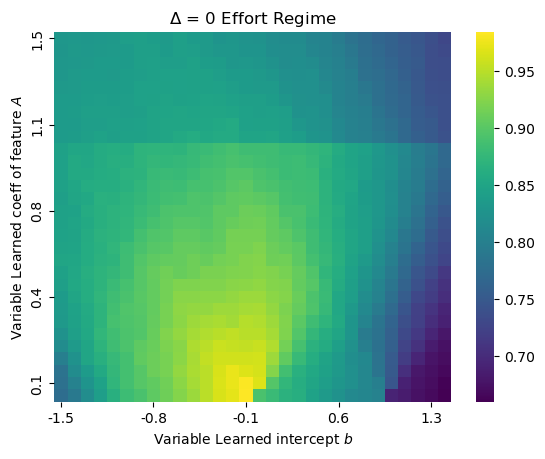

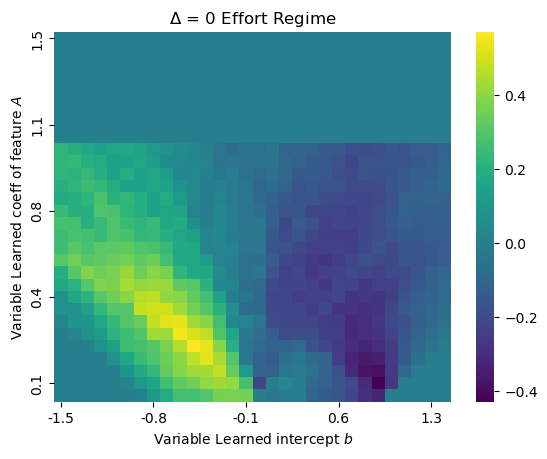

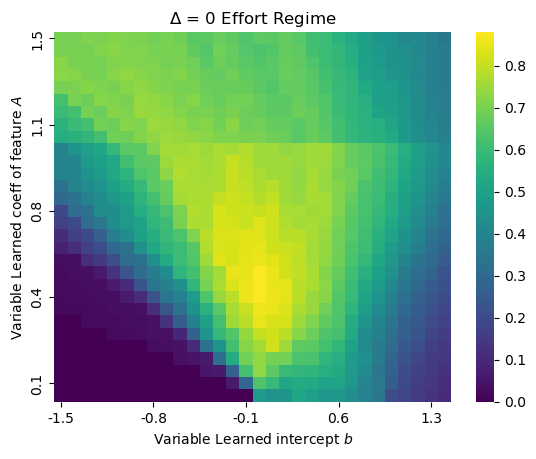

In [26]:
#for k, b in enumerate(np.arange(-1.5, 1.5, 0.5)):
#  print("Heatmap for b = ", b)
  #graph.heat_map_effort(sim_params = test_params, results = test_results['gaming'][:,:,k,0], type_graph = "grid_search")
  #graph.heat_map_effort(sim_params = test_params, results = test_results['gaming'][:,:,k,1], type_graph = "grid_search")
graph.heat_map_effort(sim_params = test_params, results = test_results['accuracy'],
                        type_graph = "grid_search")
graph.heat_map_effort(sim_params = test_params, results = test_results['improvement'][:,:,1]-test_results['improvement'][:,:,0],
                        type_graph = "grid_search")
graph.heat_map_effort(sim_params = test_params, results = test_results['gaming'][:,:,1]-test_results['gaming'][:,:,0],
                        type_graph = "grid_search")

IMPROVABILITY


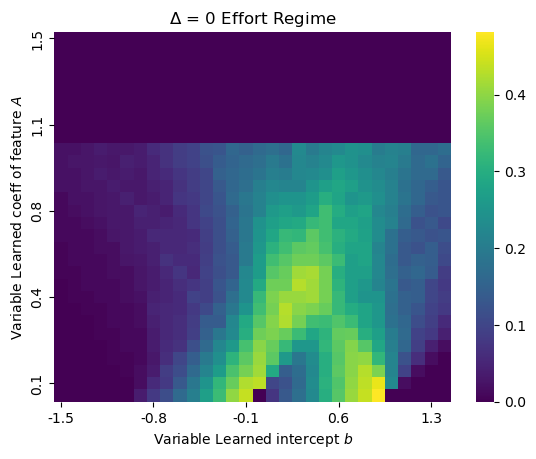

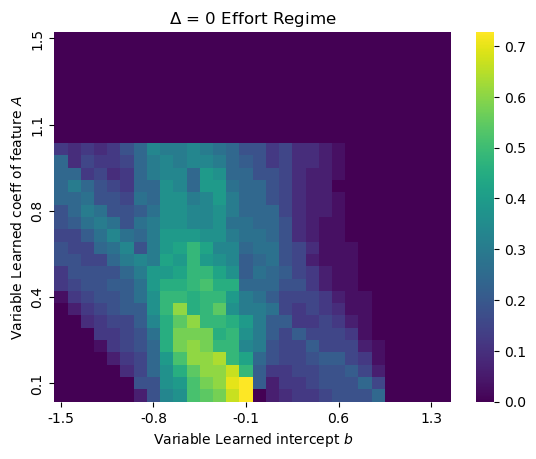

GAMING


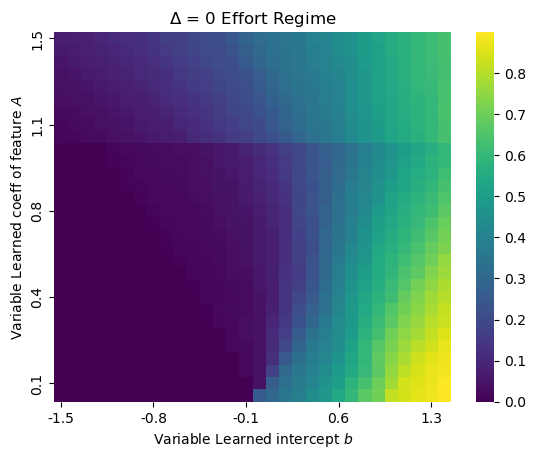

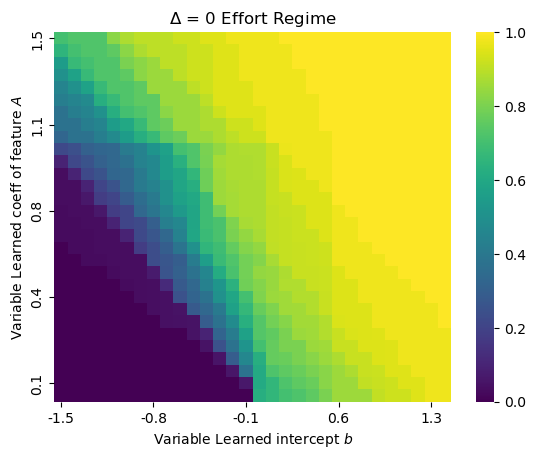

In [11]:
print("IMPROVABILITY")
graph.heat_map_effort(sim_params = test_params, results = test_results['improvement'][:,:,0],
                        type_graph = "grid_search")
graph.heat_map_effort(sim_params = test_params, results = test_results['improvement'][:,:,1],
                        type_graph = "grid_search")
print("GAMING")
graph.heat_map_effort(sim_params = test_params, results = test_results['gaming'][:,:,0],
                        type_graph = "grid_search")
graph.heat_map_effort(sim_params = test_params, results = test_results['gaming'][:,:,1],
                        type_graph = "grid_search")

U = 0


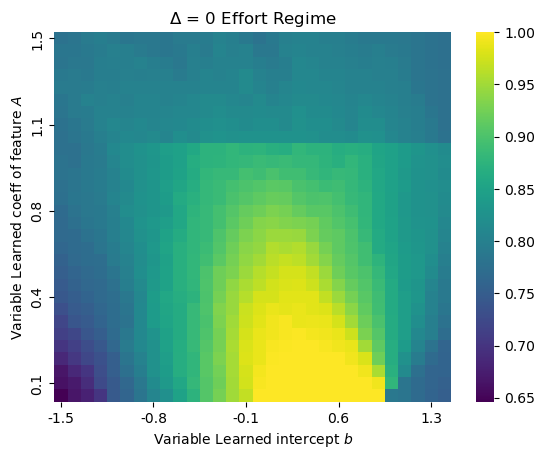

U = 1


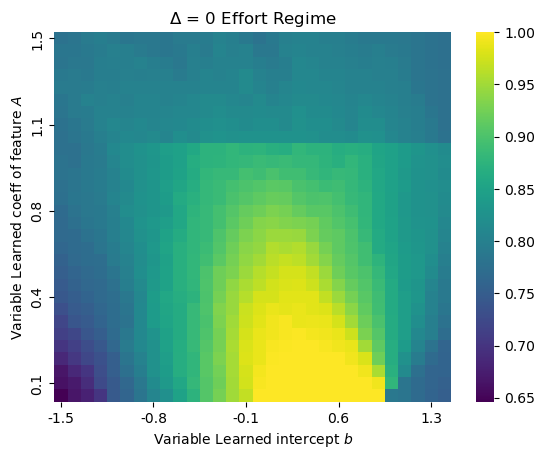

U = 0


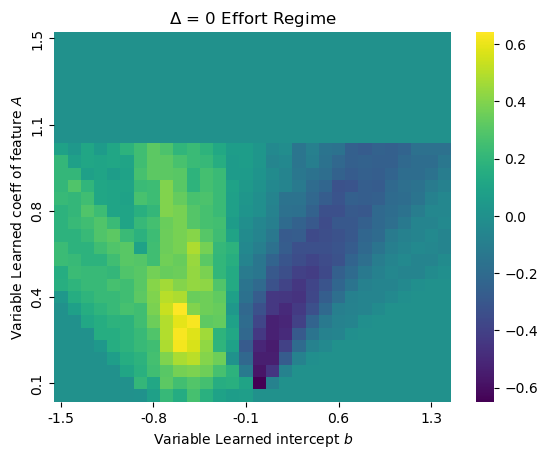

U = 1


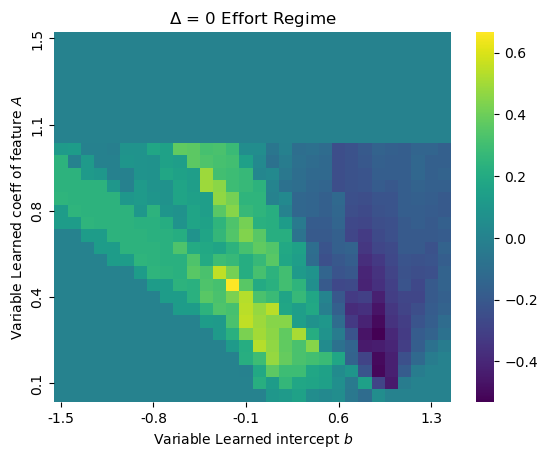

U = 0


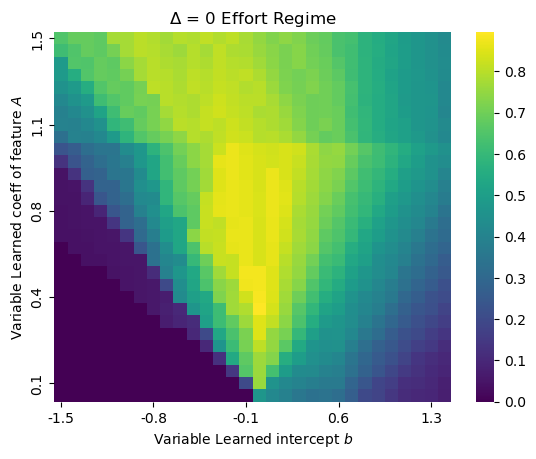

U = 1


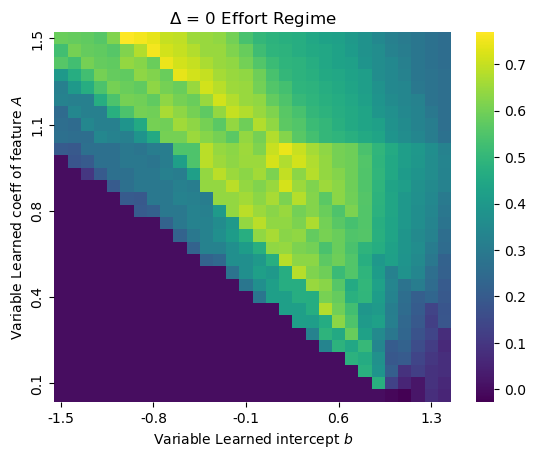

In [12]:
print("U = 0")
graph.heat_map_effort(sim_params = test_params, results = test_results['accuracy_U'][:,:,0],
                        type_graph = "grid_search")
print("U = 1")
graph.heat_map_effort(sim_params = test_params, results = test_results['accuracy_U'][:,:,1],
                        type_graph = "grid_search")

print("U = 0")
graph.heat_map_effort(sim_params = test_params, results = test_results['improvement_U'][:,:,0,1]-test_results['improvement_U'][:,:,0,0],
                        type_graph = "grid_search")
print("U = 1")
graph.heat_map_effort(sim_params = test_params, results = test_results['improvement_U'][:,:,1,1]-test_results['improvement_U'][:,:,1,0],
                        type_graph = "grid_search")
print("U = 0")
graph.heat_map_effort(sim_params = test_params, results = test_results['gaming_U'][:,:,0,1]-test_results['gaming_U'][:,:,0,0],
                        type_graph = "grid_search")
print("U = 1")
graph.heat_map_effort(sim_params = test_params, results = test_results['gaming_U'][:,:,1,1]-test_results['gaming_U'][:,:,1,0],
                        type_graph = "grid_search")

GAMING PENALTY LOSS
Epoch [100/4500], Loss: 0.9369195699691772, Accuracy: 0.7129999995231628
Coefficients: w=[-0.1486785113811493, 0.6095383763313293], b=0.21621131896972656


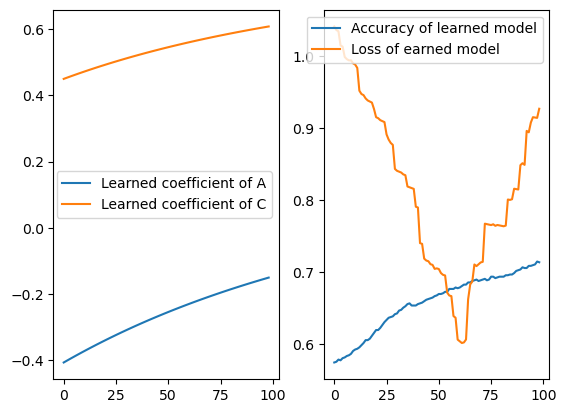

Epoch [200/4500], Loss: 1.0844590663909912, Accuracy: 0.7250000238418579
Coefficients: w=[-0.014128375798463821, 0.6882700324058533], b=0.23568424582481384


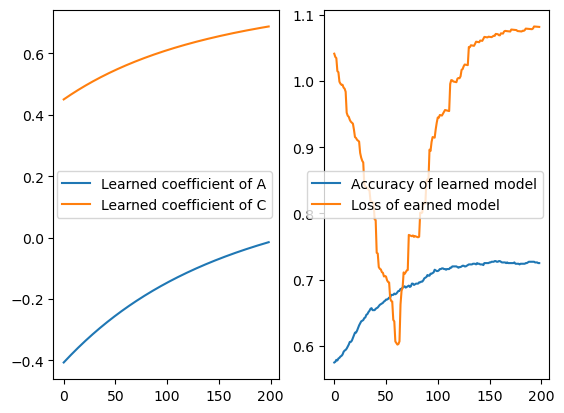

KeyboardInterrupt: 

In [111]:
#plot_logistic_regression(default_params.copy(), delta = 0.5, type_loss = "gaming", penalty_coef = 1.0, save = False)


BCE LOSS
Epoch [100/4500], Loss: 40.98207092285156, Accuracy: 0.3370000123977661
Coefficients: w=[0.14448614418506622, -0.45742344856262207], b=0.11340553313493729


/var/folders/7j/ml4pqlp16g52s4fwt3bjzz4c0000gn/T/ipykernel_1363/804043104.py:83: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  improve_vec = torch.tensor(temp_improve_vec, requires_grad=True)
/var/folders/7j/ml4pqlp16g52s4fwt3bjzz4c0000gn/T/ipykernel_1363/2037650904.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  delta_filter = torch.tensor((torch.sum(improve_vec, axis=1) <= delta))
/var/folders/7j/ml4pqlp16g52s4fwt3bjzz4c0000gn/T/ipykernel_1363/2037650904.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  improve_vec_delta = tor

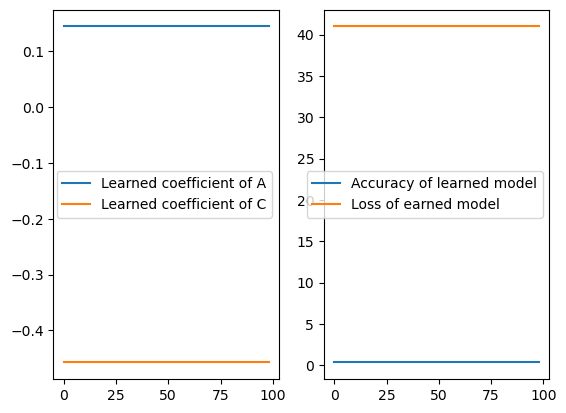

Epoch [200/4500], Loss: 40.98207092285156, Accuracy: 0.3370000123977661
Coefficients: w=[0.14448614418506622, -0.45742344856262207], b=0.11340553313493729


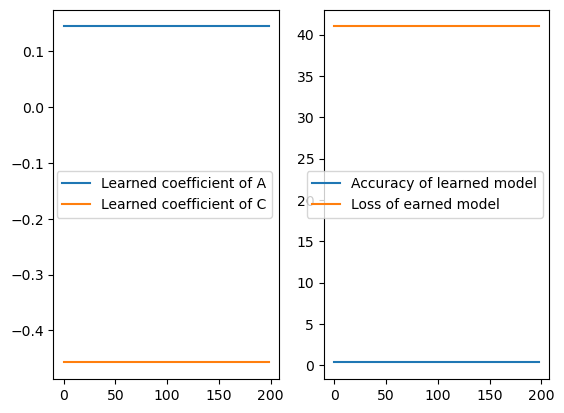

Epoch [300/4500], Loss: 40.98207092285156, Accuracy: 0.3370000123977661
Coefficients: w=[0.14448614418506622, -0.45742344856262207], b=0.11340553313493729


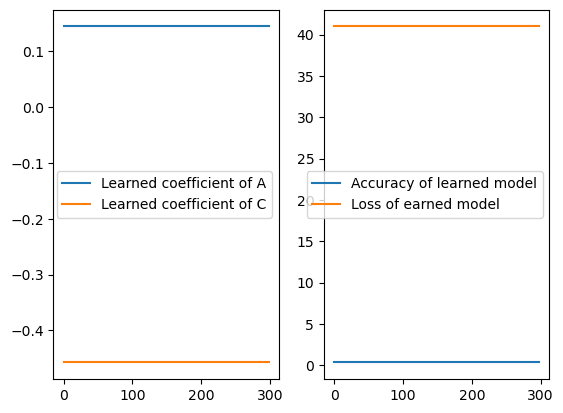

Epoch [400/4500], Loss: 40.98207092285156, Accuracy: 0.3370000123977661
Coefficients: w=[0.14448614418506622, -0.45742344856262207], b=0.11340553313493729


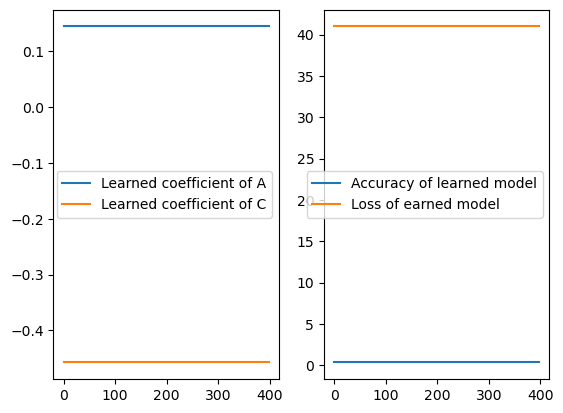

Epoch [500/4500], Loss: 40.98207092285156, Accuracy: 0.3370000123977661
Coefficients: w=[0.14448614418506622, -0.45742344856262207], b=0.11340553313493729


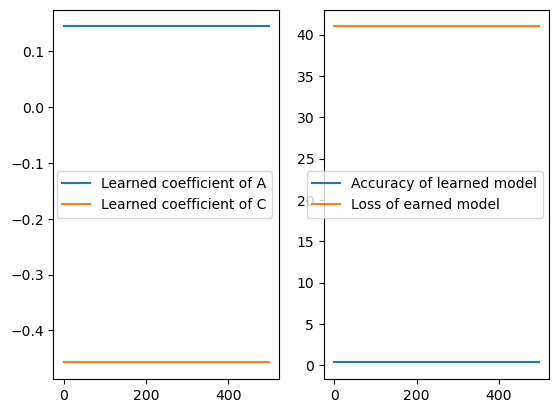

Epoch [600/4500], Loss: 40.98207092285156, Accuracy: 0.3370000123977661
Coefficients: w=[0.14448614418506622, -0.45742344856262207], b=0.11340553313493729


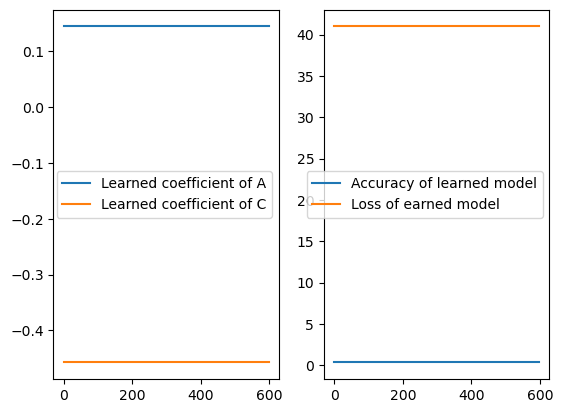

Epoch [700/4500], Loss: 40.98207092285156, Accuracy: 0.3370000123977661
Coefficients: w=[0.14448614418506622, -0.45742344856262207], b=0.11340553313493729


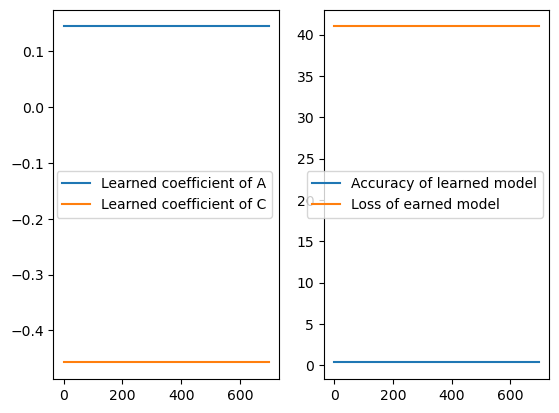

Epoch [800/4500], Loss: 40.98207092285156, Accuracy: 0.3370000123977661
Coefficients: w=[0.14448614418506622, -0.45742344856262207], b=0.11340553313493729


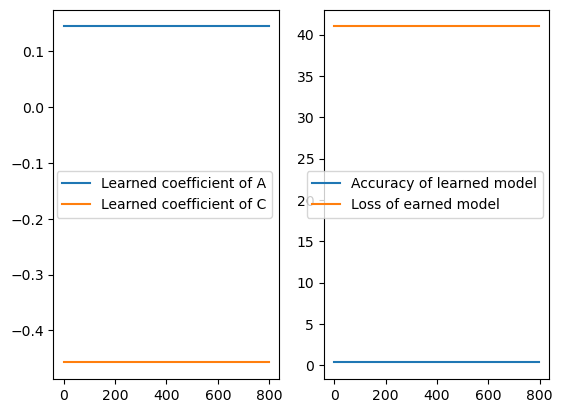

Epoch [900/4500], Loss: 40.98207092285156, Accuracy: 0.3370000123977661
Coefficients: w=[0.14448614418506622, -0.45742344856262207], b=0.11340553313493729


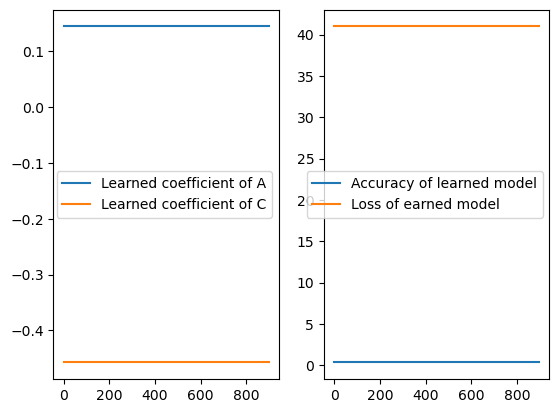

Epoch [1000/4500], Loss: 40.98207092285156, Accuracy: 0.3370000123977661
Coefficients: w=[0.14448614418506622, -0.45742344856262207], b=0.11340553313493729


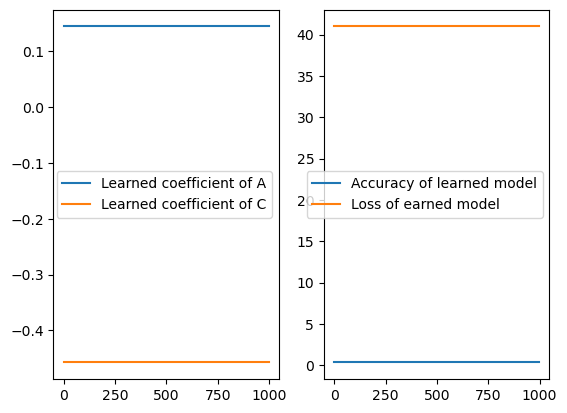

Epoch [1100/4500], Loss: 40.98207092285156, Accuracy: 0.3370000123977661
Coefficients: w=[0.14448614418506622, -0.45742344856262207], b=0.11340553313493729


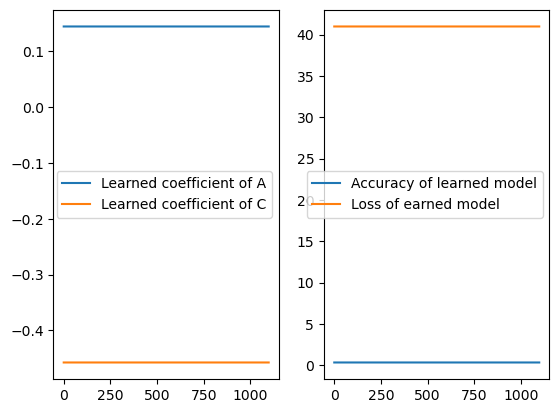

Epoch [1200/4500], Loss: 40.98207092285156, Accuracy: 0.3370000123977661
Coefficients: w=[0.14448614418506622, -0.45742344856262207], b=0.11340553313493729


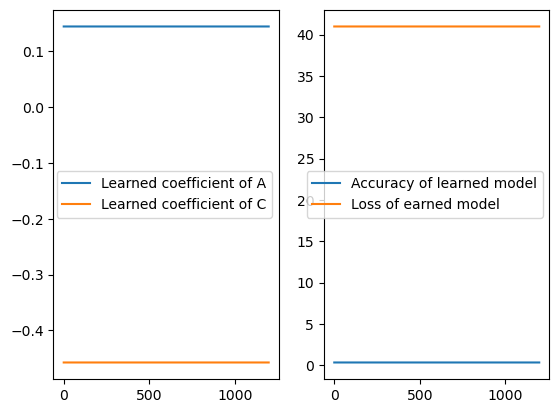

Epoch [1300/4500], Loss: 40.98207092285156, Accuracy: 0.3370000123977661
Coefficients: w=[0.14448614418506622, -0.45742344856262207], b=0.11340553313493729


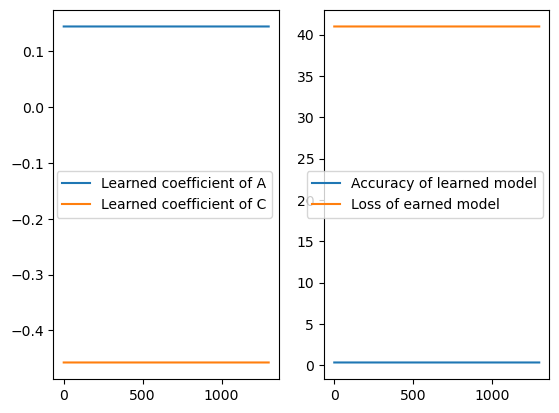

Epoch [1400/4500], Loss: 40.98207092285156, Accuracy: 0.3370000123977661
Coefficients: w=[0.14448614418506622, -0.45742344856262207], b=0.11340553313493729


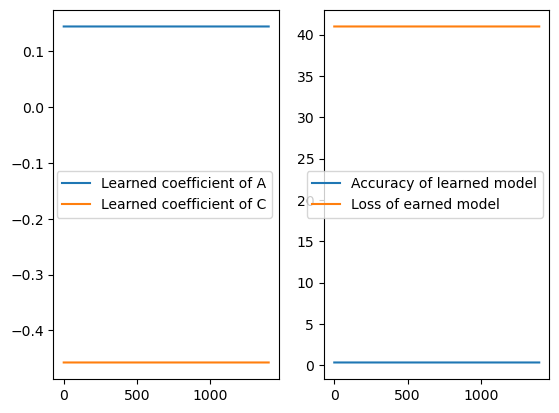

Epoch [1500/4500], Loss: 40.98207092285156, Accuracy: 0.3370000123977661
Coefficients: w=[0.14448614418506622, -0.45742344856262207], b=0.11340553313493729


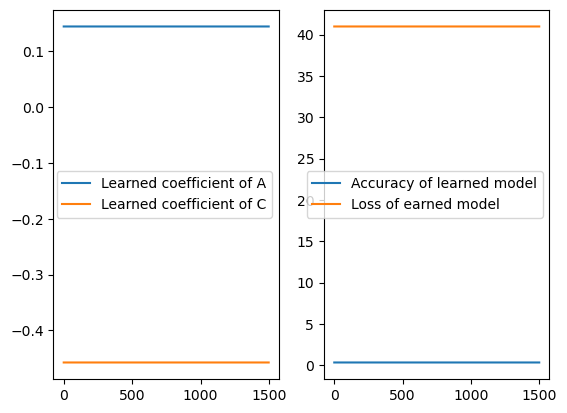

Epoch [1600/4500], Loss: 40.98207092285156, Accuracy: 0.3370000123977661
Coefficients: w=[0.14448614418506622, -0.45742344856262207], b=0.11340553313493729


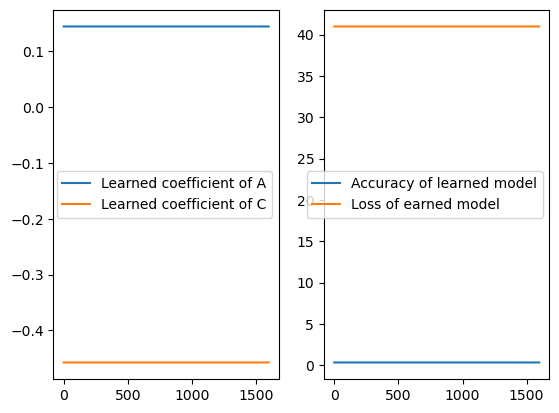

Epoch [1700/4500], Loss: 40.98207092285156, Accuracy: 0.3370000123977661
Coefficients: w=[0.14448614418506622, -0.45742344856262207], b=0.11340553313493729


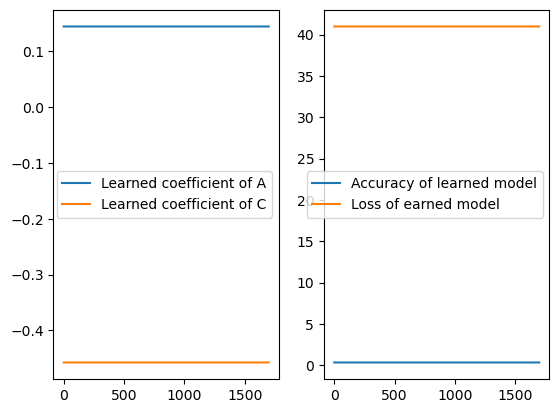

Epoch [1800/4500], Loss: 40.98207092285156, Accuracy: 0.3370000123977661
Coefficients: w=[0.14448614418506622, -0.45742344856262207], b=0.11340553313493729


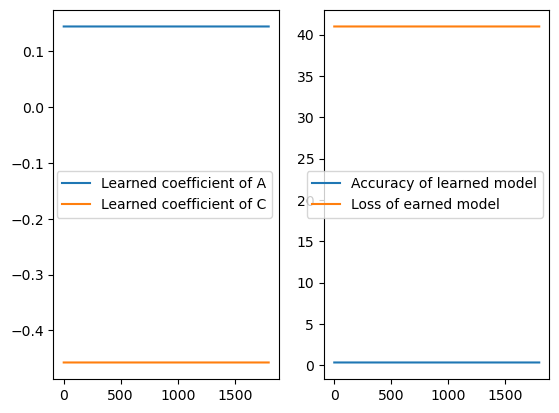

Epoch [1900/4500], Loss: 40.98207092285156, Accuracy: 0.3370000123977661
Coefficients: w=[0.14448614418506622, -0.45742344856262207], b=0.11340553313493729


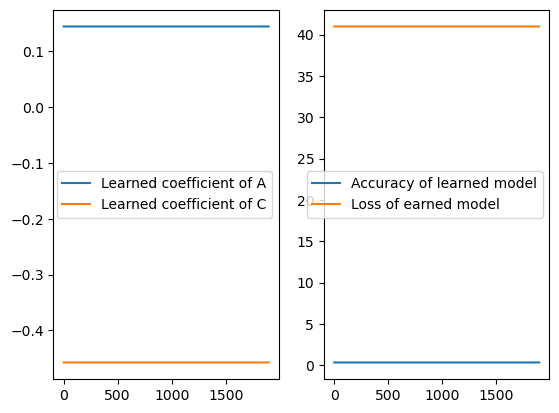

Epoch [2000/4500], Loss: 40.98207092285156, Accuracy: 0.3370000123977661
Coefficients: w=[0.14448614418506622, -0.45742344856262207], b=0.11340553313493729


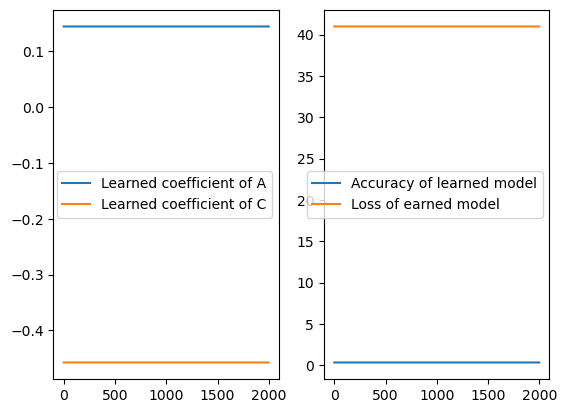

Epoch [2100/4500], Loss: 40.98207092285156, Accuracy: 0.3370000123977661
Coefficients: w=[0.14448614418506622, -0.45742344856262207], b=0.11340553313493729


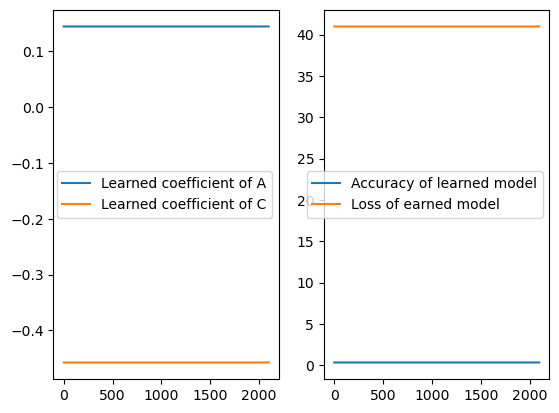

Epoch [2200/4500], Loss: 40.98207092285156, Accuracy: 0.3370000123977661
Coefficients: w=[0.14448614418506622, -0.45742344856262207], b=0.11340553313493729


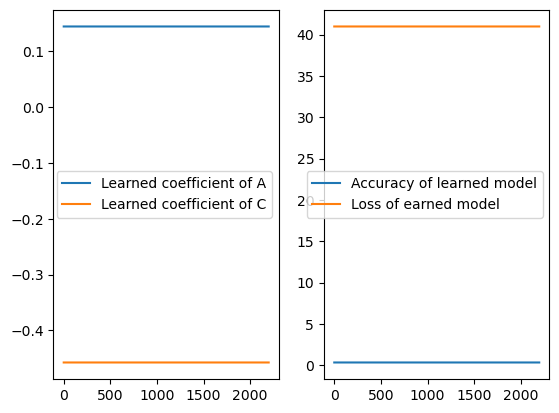

Epoch [2300/4500], Loss: 40.98207092285156, Accuracy: 0.3370000123977661
Coefficients: w=[0.14448614418506622, -0.45742344856262207], b=0.11340553313493729


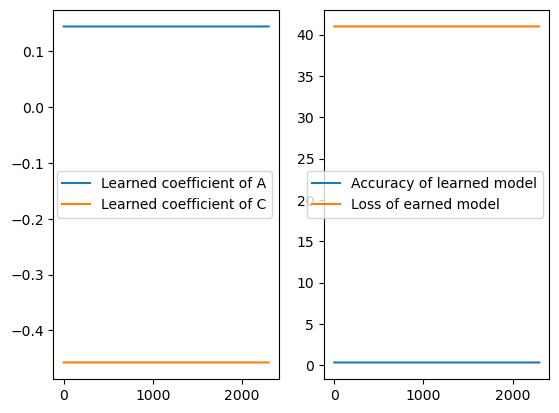

Epoch [2400/4500], Loss: 40.98207092285156, Accuracy: 0.3370000123977661
Coefficients: w=[0.14448614418506622, -0.45742344856262207], b=0.11340553313493729


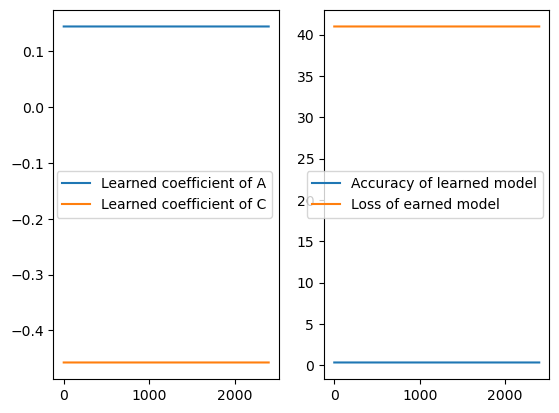

Epoch [2500/4500], Loss: 40.98207092285156, Accuracy: 0.3370000123977661
Coefficients: w=[0.14448614418506622, -0.45742344856262207], b=0.11340553313493729


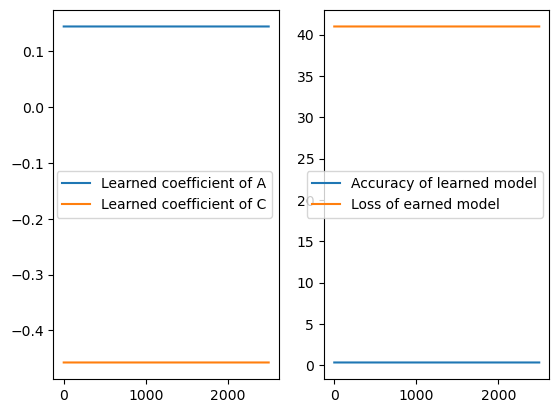

Epoch [2600/4500], Loss: 40.98207092285156, Accuracy: 0.3370000123977661
Coefficients: w=[0.14448614418506622, -0.45742344856262207], b=0.11340553313493729


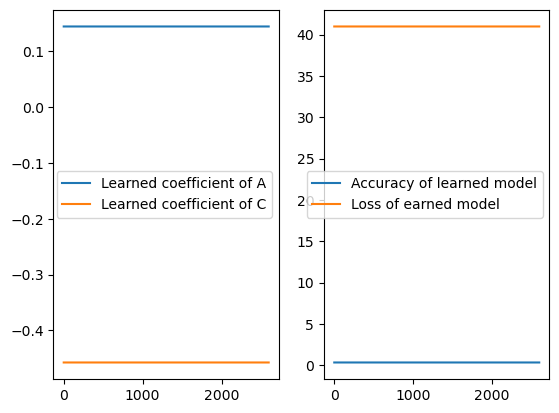

Epoch [2700/4500], Loss: 40.98207092285156, Accuracy: 0.3370000123977661
Coefficients: w=[0.14448614418506622, -0.45742344856262207], b=0.11340553313493729


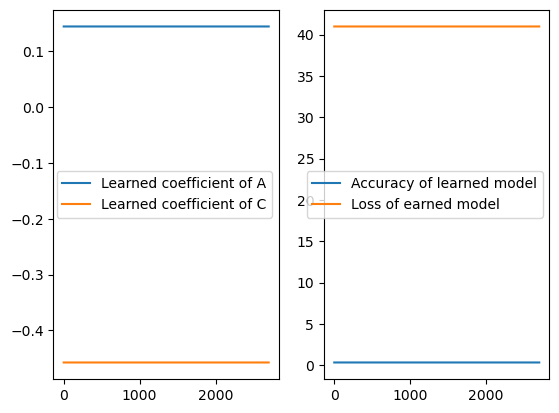

Epoch [2800/4500], Loss: 40.98207092285156, Accuracy: 0.3370000123977661
Coefficients: w=[0.14448614418506622, -0.45742344856262207], b=0.11340553313493729


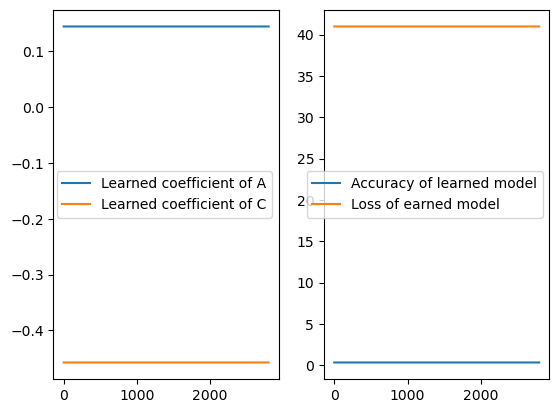

Epoch [2900/4500], Loss: 40.98207092285156, Accuracy: 0.3370000123977661
Coefficients: w=[0.14448614418506622, -0.45742344856262207], b=0.11340553313493729


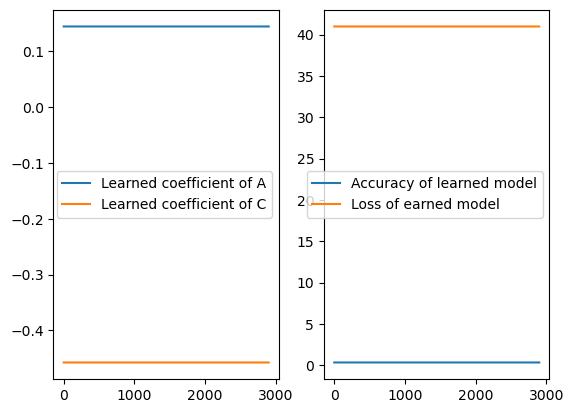

Epoch [3000/4500], Loss: 40.98207092285156, Accuracy: 0.3370000123977661
Coefficients: w=[0.14448614418506622, -0.45742344856262207], b=0.11340553313493729


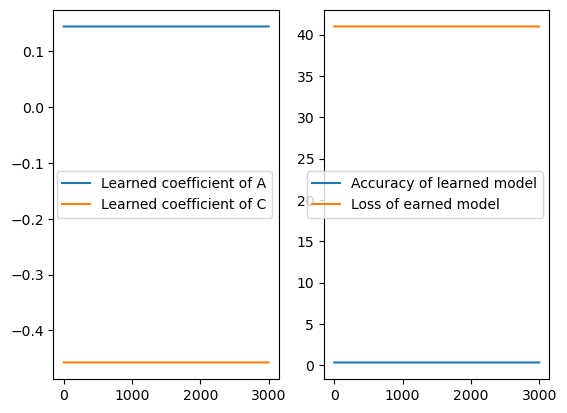

Epoch [3100/4500], Loss: 40.98207092285156, Accuracy: 0.3370000123977661
Coefficients: w=[0.14448614418506622, -0.45742344856262207], b=0.11340553313493729


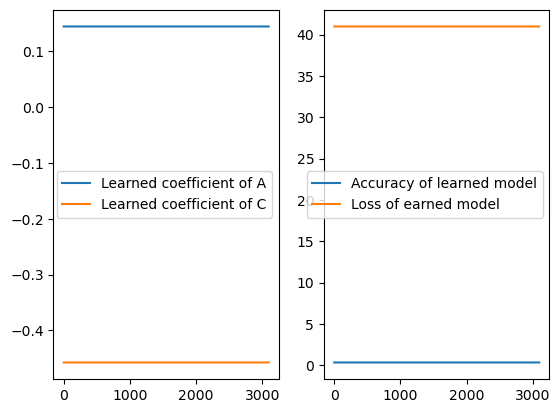

Epoch [3200/4500], Loss: 40.98207092285156, Accuracy: 0.3370000123977661
Coefficients: w=[0.14448614418506622, -0.45742344856262207], b=0.11340553313493729


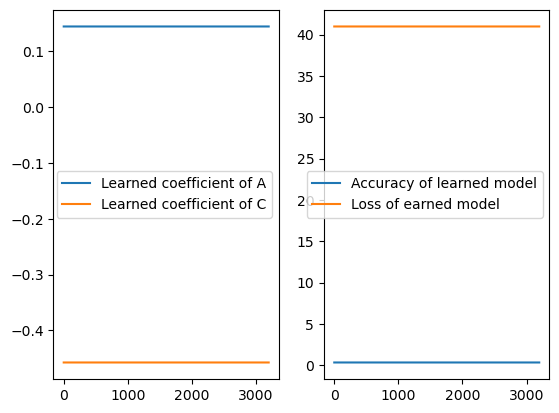

Epoch [3300/4500], Loss: 40.98207092285156, Accuracy: 0.3370000123977661
Coefficients: w=[0.14448614418506622, -0.45742344856262207], b=0.11340553313493729


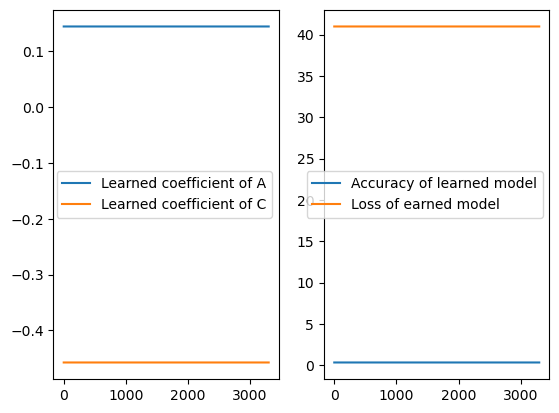

Epoch [3400/4500], Loss: 40.98207092285156, Accuracy: 0.3370000123977661
Coefficients: w=[0.14448614418506622, -0.45742344856262207], b=0.11340553313493729


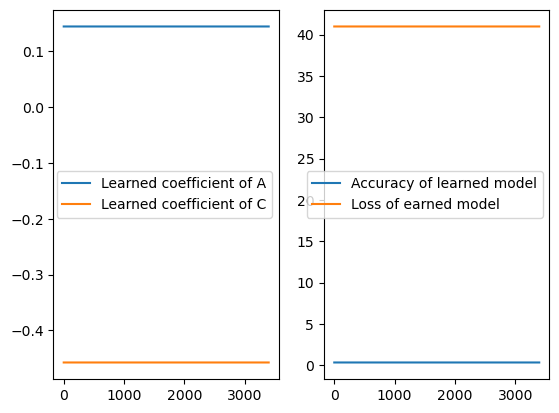

Epoch [3500/4500], Loss: 40.98207092285156, Accuracy: 0.3370000123977661
Coefficients: w=[0.14448614418506622, -0.45742344856262207], b=0.11340553313493729


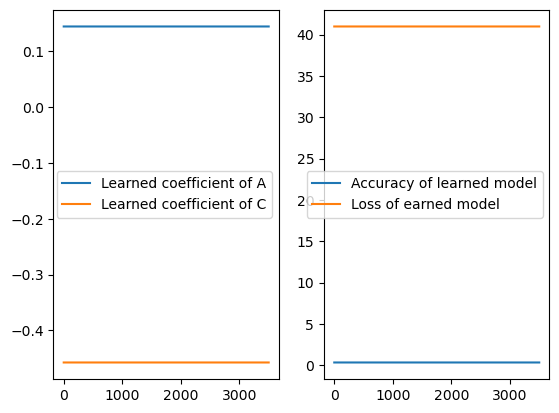

Epoch [3600/4500], Loss: 40.98207092285156, Accuracy: 0.3370000123977661
Coefficients: w=[0.14448614418506622, -0.45742344856262207], b=0.11340553313493729


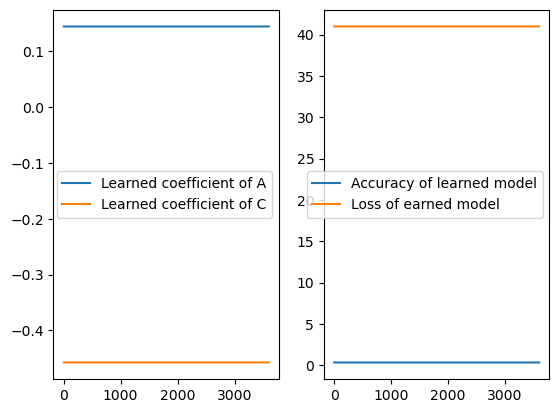

Epoch [3700/4500], Loss: 40.98207092285156, Accuracy: 0.3370000123977661
Coefficients: w=[0.14448614418506622, -0.45742344856262207], b=0.11340553313493729


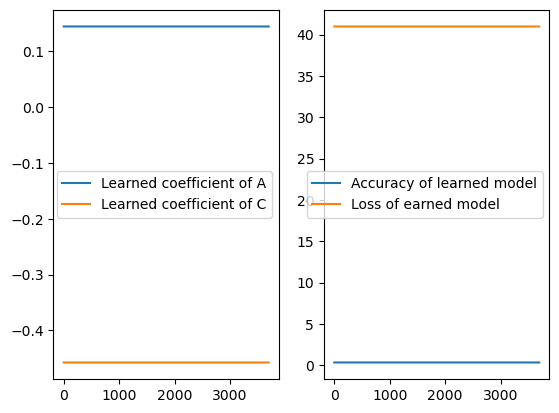

Epoch [3800/4500], Loss: 40.98207092285156, Accuracy: 0.3370000123977661
Coefficients: w=[0.14448614418506622, -0.45742344856262207], b=0.11340553313493729


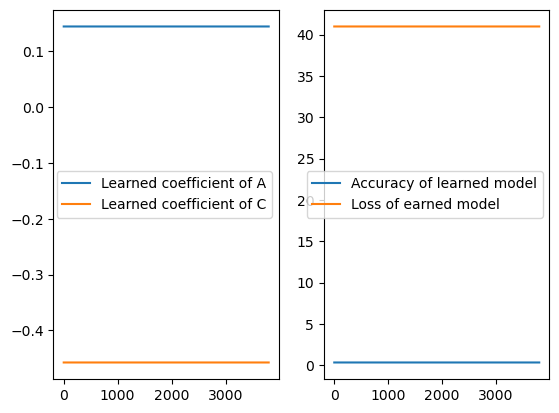

Epoch [3900/4500], Loss: 40.98207092285156, Accuracy: 0.3370000123977661
Coefficients: w=[0.14448614418506622, -0.45742344856262207], b=0.11340553313493729


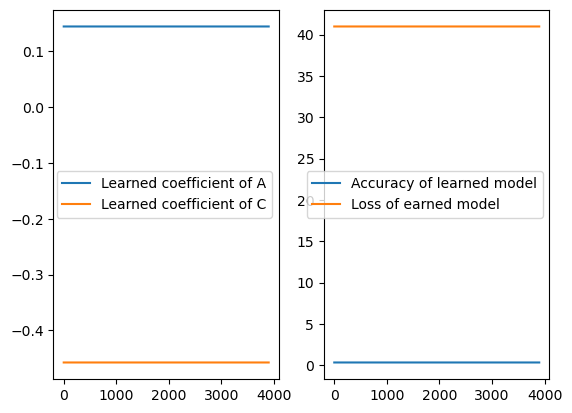

Epoch [4000/4500], Loss: 40.98207092285156, Accuracy: 0.3370000123977661
Coefficients: w=[0.14448614418506622, -0.45742344856262207], b=0.11340553313493729


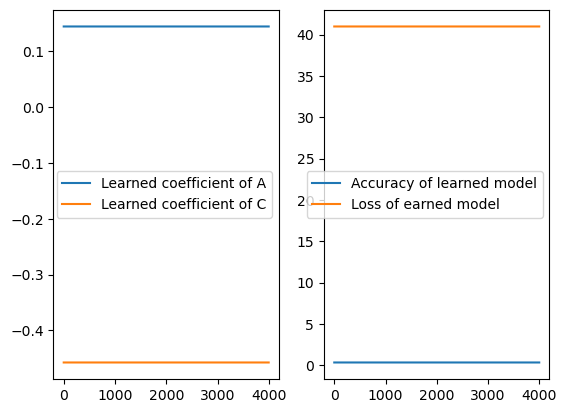

Epoch [4100/4500], Loss: 40.98207092285156, Accuracy: 0.3370000123977661
Coefficients: w=[0.14448614418506622, -0.45742344856262207], b=0.11340553313493729


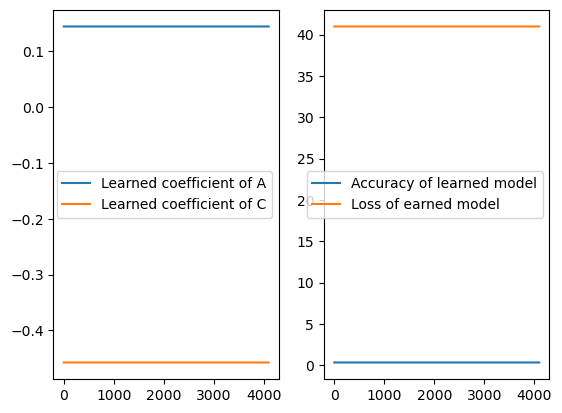

Epoch [4200/4500], Loss: 40.98207092285156, Accuracy: 0.3370000123977661
Coefficients: w=[0.14448614418506622, -0.45742344856262207], b=0.11340553313493729


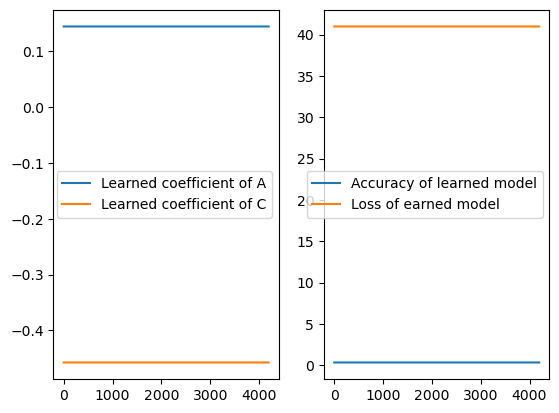

Epoch [4300/4500], Loss: 40.98207092285156, Accuracy: 0.3370000123977661
Coefficients: w=[0.14448614418506622, -0.45742344856262207], b=0.11340553313493729


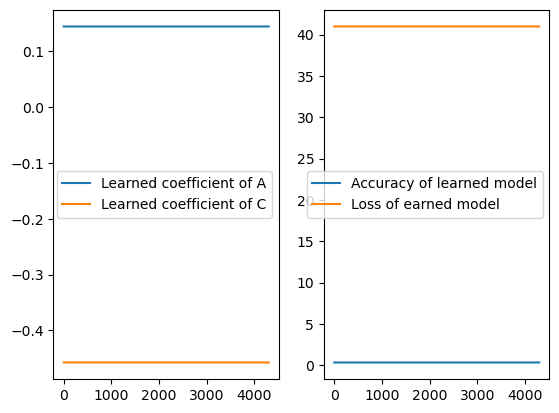

Epoch [4400/4500], Loss: 40.98207092285156, Accuracy: 0.3370000123977661
Coefficients: w=[0.14448614418506622, -0.45742344856262207], b=0.11340553313493729


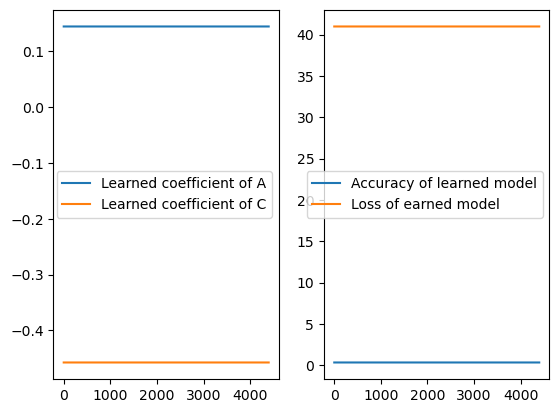

Epoch [4500/4500], Loss: 40.98207092285156, Accuracy: 0.3370000123977661
Coefficients: w=[0.14448614418506622, -0.45742344856262207], b=0.11340553313493729


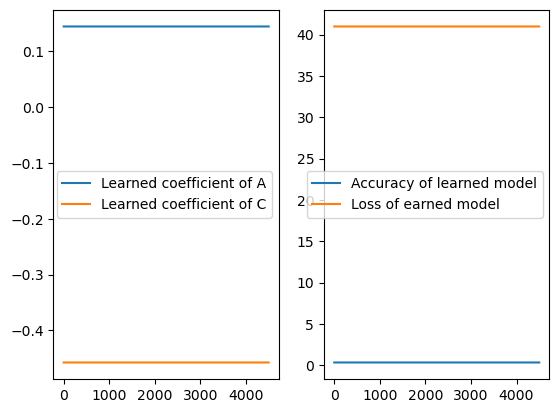

0.487
0.4749696390668322


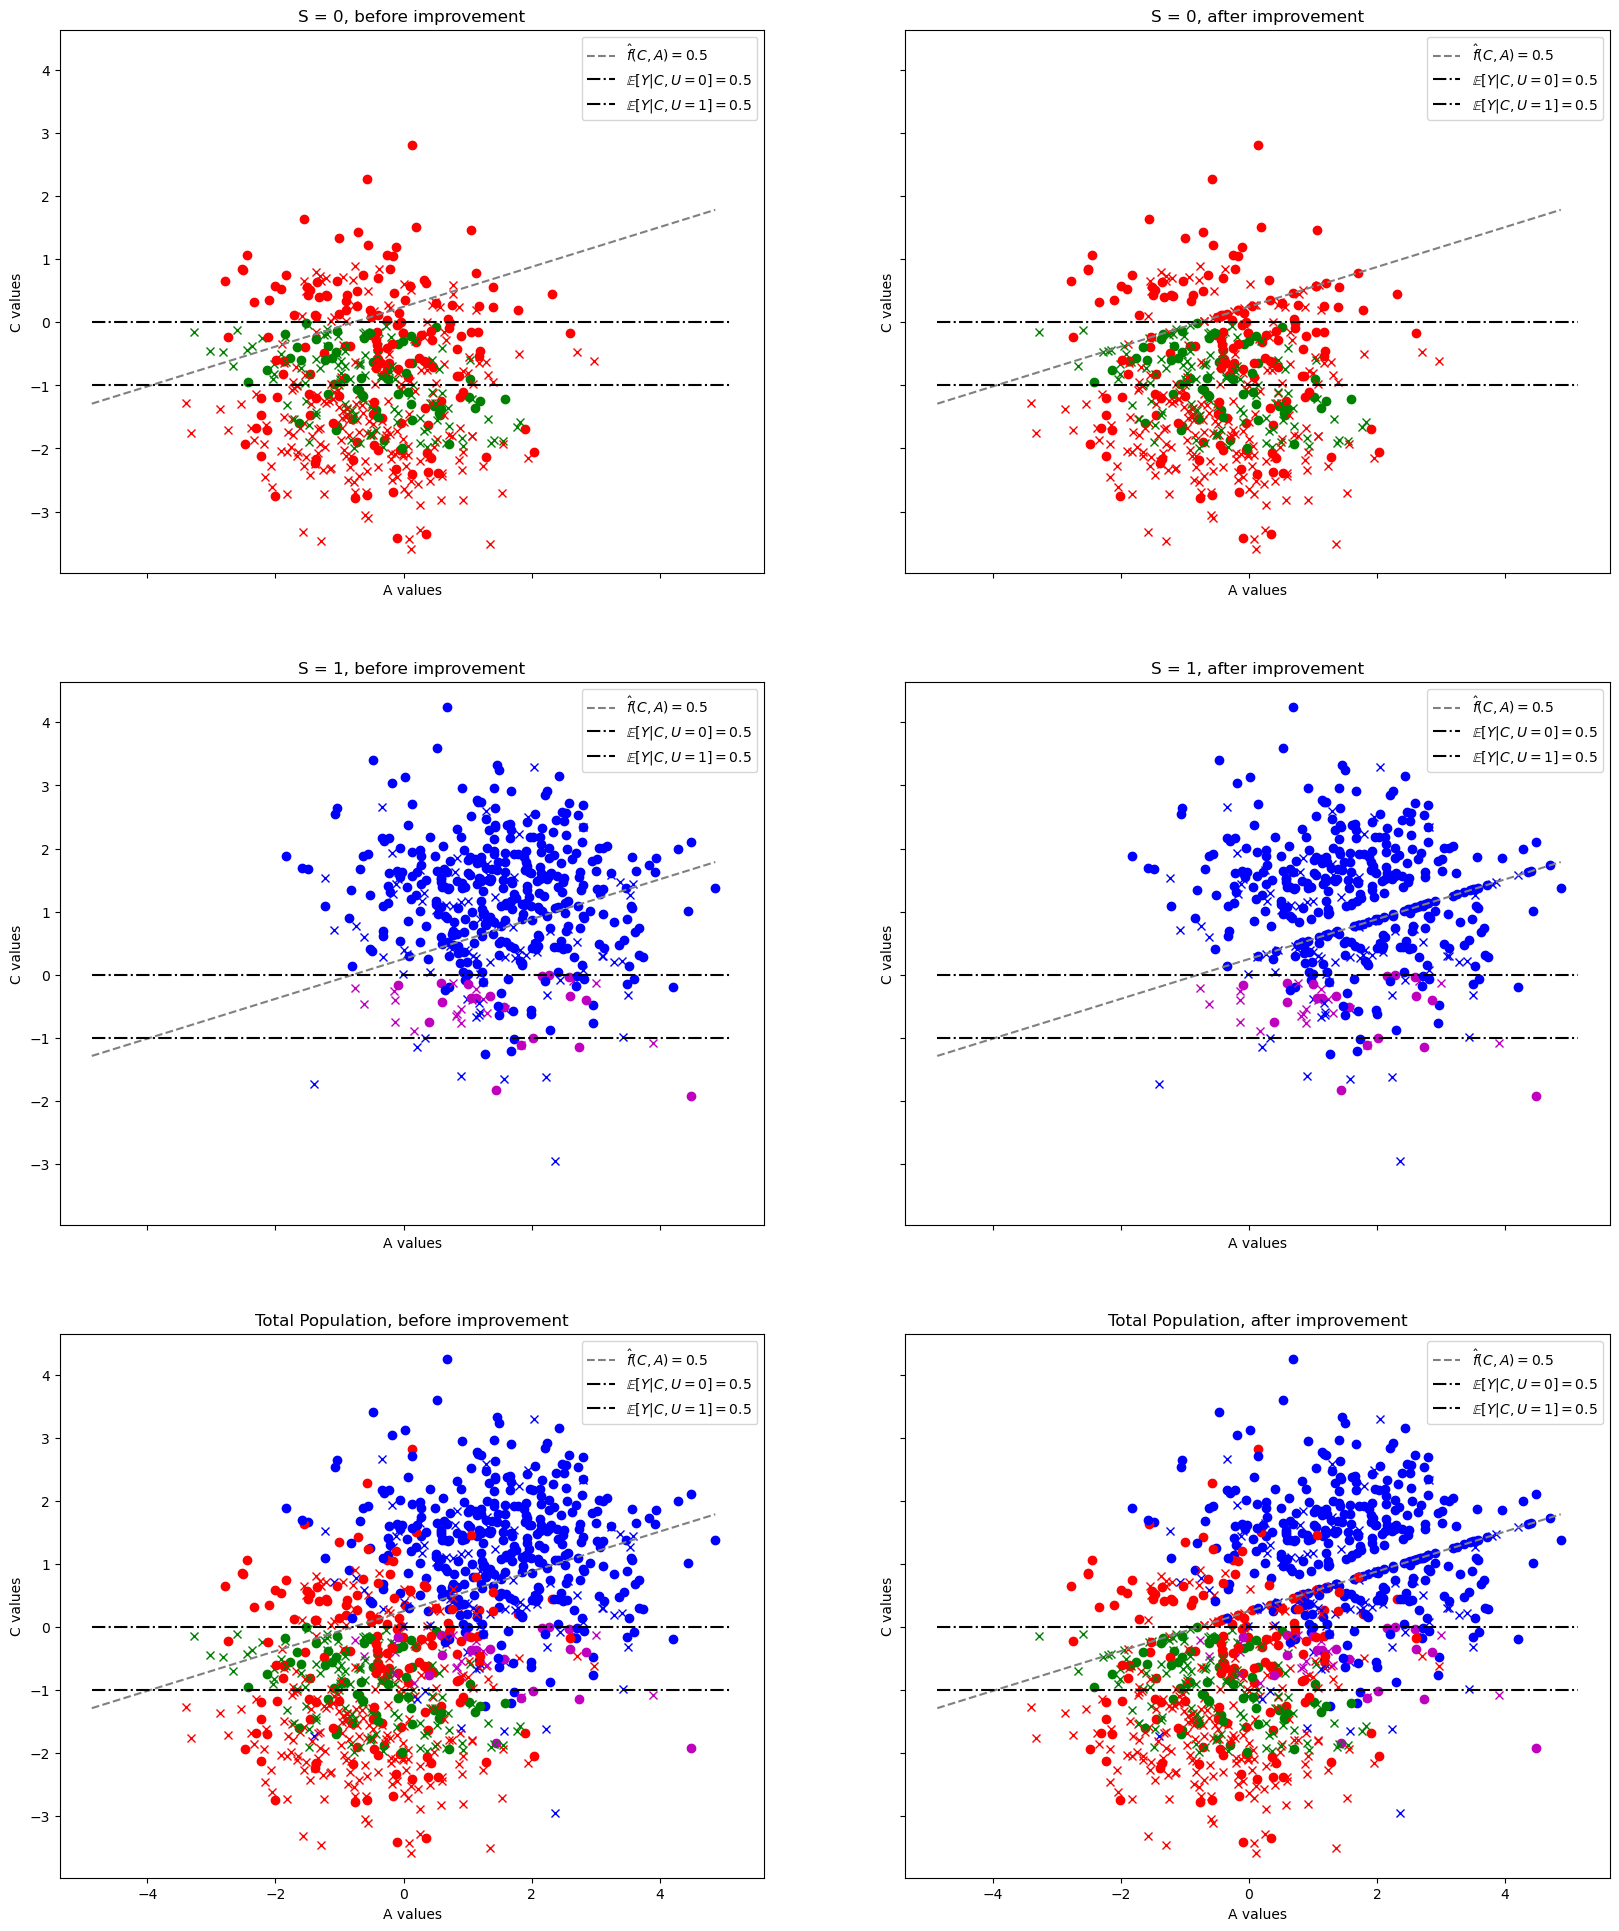

In [214]:
#plot_improvement(default_params.copy(), delta = 1, save = False)